In [1]:
# !pip install bitsandbytes --quiet

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np
import pandas as pd
import json
import math
from torch import Tensor
from torchmetrics.text import BLEUScore
import copy
from pytz import timezone
import datetime
import os
from sklearn.model_selection import train_test_split
import bitsandbytes as bnb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
class Config:
    D_MODEL = 256
    BATCH_SIZE = 16
    MHA_NUMHEADS = 8

    FF_DROPOUT = 0.15
    MHA_DROPOUT = 0.15
    PE_DROP_OUT = 0.15

    EPSILON_TERM = 1e-5

    N_ENCODERS = 3
    N_DECODERS = 3

    FF_SCALE = 4

    LEARNING_RATE = 1e-3

    MAX_LEN = 128

    SRC_VOCAB_SIZE = 45864
    # Target là Tiếng Anh
    TGT_VOCAB_SIZE = 69025

    EPOCHS = 3

config_dict = {k.lower(): v for k, v in Config.__dict__.items() if not k.startswith("__")}

In [4]:
DATA_DIR="../data/med-ev"
EN2ID_DIR = f"{DATA_DIR}/en_token2id.json"
ID2EN_DIR = f"{DATA_DIR}/en_id2token.json"
VI2ID_DIR = f"{DATA_DIR}/vi_token2id.json"
ID2VI_DIR = f"{DATA_DIR}/vi_id2token.json"
TRAIN_DIR = f"{DATA_DIR}/train.csv"
TEST_DIR = f"{DATA_DIR}/test.csv"
VAL_DIR = f"{DATA_DIR}/val.csv"

train_df = pd.read_csv(TRAIN_DIR)
test_df = pd.read_csv(TEST_DIR)
val_df = pd.read_csv(VAL_DIR)

def load_json(path):
    with open(path, "r", encoding='utf-8') as f: 
        return json.load(f)

en_token2id = load_json(EN2ID_DIR)
en_id2token = load_json(ID2EN_DIR)
vi_token2id = load_json(VI2ID_DIR)
vi_id2token = load_json(ID2VI_DIR)

EN_UNK_ID = en_token2id['<unk>']
EN_PAD_ID = en_token2id['<pad>']
EN_SOS_ID = en_token2id['<s>']
EN_EOS_ID = en_token2id['</s>']

VI_UNK_ID = vi_token2id['<unk>']
VI_PAD_ID = vi_token2id['<pad>']
VI_SOS_ID = vi_token2id['<s>']
VI_EOS_ID = vi_token2id['</s>']

print("EN Special IDs:", EN_UNK_ID, EN_PAD_ID, EN_SOS_ID, EN_EOS_ID)
print("VI Special IDs:", VI_UNK_ID, VI_PAD_ID, VI_SOS_ID, VI_EOS_ID)

VI_VOCAB_LEN = len(vi_token2id)
EN_VOCAB_LEN = len(en_token2id)

Config.SRC_VOCAB_SIZE = VI_VOCAB_LEN
Config.TGT_VOCAB_SIZE = EN_VOCAB_LEN

print(f"Config updated: SRC={Config.SRC_VOCAB_SIZE}, TGT={Config.TGT_VOCAB_SIZE}")

EN Special IDs: 0 1 2 3
VI Special IDs: 0 1 2 3
Config updated: SRC=45864, TGT=69025


In [5]:
train_df = pd.read_csv(TRAIN_DIR)
val_df = pd.read_csv(VAL_DIR) 
test_df = pd.read_csv(TEST_DIR)

def tokenize_data(text, token2id, unk_id, sos_id, eos_id, max_len):
    if not isinstance(text, str): return []
    ids = [token2id.get(token, unk_id) for token in text.split()]
    if max_len is not None:
        ids = ids[:max_len - 2]
    return [sos_id] + ids + [eos_id]

for df in [train_df, val_df, test_df]:
    df['vi_token'] = df['vi'].apply(
        lambda x: tokenize_data(x, vi_token2id, VI_UNK_ID, VI_SOS_ID, VI_EOS_ID, Config.MAX_LEN)
    )
    df['en_token'] = df['en'].apply(
        lambda x: tokenize_data(x, en_token2id, EN_UNK_ID, EN_SOS_ID, EN_EOS_ID, Config.MAX_LEN)
    )


print(f"Train size: {len(train_df)}")
print("Sample VI (Must start/end with special IDs):", train_df['vi_token'].iloc[0][:5], "...", train_df['vi_token'].iloc[0][-2:])
print("Sample EN (Must start/end with special IDs):", train_df['en_token'].iloc[0][:5], "...", train_df['en_token'].iloc[0][-2:])

print("Max len VI check:", train_df['vi_token'].map(len).max())
print("Max len EN check:", train_df['en_token'].map(len).max())

train_df.head()

Train size: 340897
Sample VI (Must start/end with special IDs): [2, 26, 134, 66, 4] ... [2577, 3]
Sample EN (Must start/end with special IDs): [2, 12, 150, 50, 4] ... [38, 3]
Max len VI check: 128
Max len EN check: 128


,en,vi,vi_token,en_token
0,"to evaluate clinical , subclinical symptoms of...","nghiên_cứu đặc_điểm lâm_sàng , cận lâm_sàng bệ...","[2, 26, 134, 66, 4, 384, 66, 18, 54, 479, 1376...","[2, 12, 150, 50, 4, 1050, 63, 7, 18, 15, 2380,..."
1,"evaluate clinical , subclinical symptoms of pa...","đánh_giá đặc_điểm lâm_sàng , cận lâm_sàng bệnh...","[2, 58, 134, 66, 4, 384, 66, 18, 54, 479, 1376...","[2, 150, 50, 4, 1050, 63, 7, 18, 15, 51982, 12..."
2,there was a relation between vasodilatation an...,có sự liên_quan giữa độ quá phát v . a với mức...,"[2, 10, 50, 72, 110, 79, 426, 1017, 1114, 5, 4...","[2, 56, 21, 17, 1551, 74, 25094, 8, 841, 497, ..."
3,otittis media effusion on v a is a common dise...,kết_luận : viêm tai ứ dịch trên viêm v . a là ...,"[2, 100, 12, 54, 479, 1376, 172, 30, 54, 1114,...","[2, 51982, 1251, 1384, 28, 1456, 17, 16, 17, 7..."
4,"main symptoms are rhinitis , nasal congestion ...","triệu_chứng cơ_năng nổi_bật là chảy mũi , ngạt...","[2, 77, 1996, 2390, 13, 999, 271, 4, 6882, 6, ...","[2, 538, 63, 22, 1843, 4, 712, 3578, 4, 4185, ..."


In [6]:
class LangDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src = src_data
        self.tgt = tgt_data

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_tokens = torch.tensor(self.src[idx], dtype=torch.long)
        tgt_tokens = torch.tensor(self.tgt[idx], dtype=torch.long)   
        tgt_input = tgt_tokens[:-1]
        tgt_label = tgt_tokens[1:]
        
        return src_tokens, tgt_input, tgt_label

def collate_fn(batch):
    src_batch, tgt_in_batch, tgt_lbl_batch = zip(*batch)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=VI_PAD_ID)
    tgt_in_padded = pad_sequence(tgt_in_batch, batch_first=True, padding_value=EN_PAD_ID)
    tgt_lbl_padded = pad_sequence(tgt_lbl_batch, batch_first=True, padding_value=EN_PAD_ID)
    
    return src_padded, tgt_in_padded, tgt_lbl_padded

print("Creating DataLoaders...")

train_dataset = LangDataset(train_df['vi_token'], train_df['en_token'])
val_dataset   = LangDataset(val_df['vi_token'], val_df['en_token'])
test_dataset  = LangDataset(test_df['vi_token'], test_df['en_token'])

train_loader = DataLoader(train_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config_dict['batch_size'], collate_fn=collate_fn, shuffle=False, num_workers=2)

src_sample, tgt_in_sample, tgt_lbl_sample = next(iter(train_loader))
print("\n--- BATCH SHAPE CHECK ---")
print(f"Source (VI)      : {src_sample.shape}")  
print(f"Dec Input (EN)   : {tgt_in_sample.shape}") 
print(f"Dec Label (EN)   : {tgt_lbl_sample.shape}")

print("\nLogic Check (Dec Input vs Label):")
print("Input:", tgt_in_sample[0].tolist())
print("Label:", tgt_lbl_sample[0].tolist()) 

Creating DataLoaders...


/home/rengumin/dev/nlp-project/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- BATCH SHAPE CHECK ---
Source (VI)      : torch.Size([16, 120])
Dec Input (EN)   : torch.Size([16, 114])
Dec Label (EN)   : torch.Size([16, 114])

Logic Check (Dec Input vs Label):
Input: [2, 528, 382, 302, 4, 260, 302, 64, 124, 1337, 7, 2814, 15, 326, 3215, 8, 11364, 54, 90, 382, 302, 8, 288, 302, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Label: [528, 382, 302, 4, 260, 302, 64, 124, 1337, 7, 2814, 15, 326, 3215, 8, 11364, 54, 90, 382, 302, 8, 288, 302, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
def generate_subsequence_mask(size: int) -> Tensor:
   if not hasattr(generate_subsequence_mask, 'cache'):
       generate_subsequence_mask.cache = {}

   if size not in generate_subsequence_mask.cache:
       mask_shape = (1, 1, size, size)
       generate_subsequence_mask.cache[size] = torch.triu(torch.ones(mask_shape), 1).to(torch.bool)

   return generate_subsequence_mask.cache[size]

def generate_padding_mask(seq: Tensor, pad_id: int) -> Tensor:
   return (seq == pad_id).unsqueeze(1).unsqueeze(2)

In [8]:
# @title Multi-head attention
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout):
    super().__init__()

    assert d_model % num_heads == 0, "out_dim must be divisible by num_heads"
    self.num_heads = num_heads
    self.d_k = d_model // num_heads
    self.sqrt_dk = math.sqrt(self.d_k) # for scaled dot product

    self.W_query = nn.Linear(d_model, d_model, bias=False)
    self.W_key = nn.Linear(d_model, d_model, bias=False)
    self.W_value = nn.Linear(d_model, d_model, bias=False)
    self.out_proj = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query: Tensor, key: Tensor, value:Tensor, attn_mask=None, key_padding_mask=None)->Tensor:
    # (batch_size, query_seq_len, d_model)
    batch_size, query_seq_len, _ = query.shape

    # Self-attention: q=k=v
    if key is None: key = query
    if value is None: value = query

    key_seq_len = key.shape[1]
    value_seq_len = value.shape[1]

    Q = self.W_query(query)
    K = self.W_key(key)
    V = self.W_value(value)

    # split head (batch_size, seq_len, num_heads, d_k)
    Q = Q.view(batch_size, query_seq_len, self.num_heads, self.d_k)
    K = K.view(batch_size, key_seq_len, self.num_heads, self.d_k)
    V = V.view(batch_size, value_seq_len, self.num_heads, self.d_k)

    attn_output = self.scaled_dot_product_attention(Q, K, V, attn_mask=attn_mask, key_padding_mask=key_padding_mask)

    # (batch_size, num_heads, query_seq_len, d_k) -> (batch_size, query_seq_len, num_heads, d_k)
    attn_output = attn_output.transpose(1, 2).contiguous()

    # concat head (output sequence length matches query sequence length)
    joined_heads = attn_output.reshape(batch_size, query_seq_len, -1)

    out = self.out_proj(joined_heads)
    out = self.dropout(out)
    del Q, K, V, attn_output, joined_heads
    return out

  def scaled_dot_product_attention(self, Q: Tensor, K: Tensor, V: Tensor, attn_mask = None, key_padding_mask = None) -> Tensor:
    """
        Q: (batch_size, query_seq_len, num_heads, d_k)
        K: (batch_size, key_seq_len, num_heads, d_k)
        V: (batch_size, value_seq_len, num_heads, d_k)
        Returns:
         attention_output: (batch_size, num_heads, query_seq_len, d_k)
    """
    Q = Q.transpose(-2,-3)
    K = K.transpose(-2,-3)
    V = V.transpose(-2,-3)
    # 1. S = (q * kT)/sqrt(d_k)
    S = Q @ K.transpose(-1,-2) / self.sqrt_dk # (batch_size, num_heads, query_seq_len, key_seq_len)

    # Combine masks
    final_mask = None
    if key_padding_mask is not None:
      # key_padding_mask is (batch_size, 1, 1, key_seq_len)
      # It needs to be broadcastable with S, which means masking the last dimension (key_seq_len)
      final_mask = key_padding_mask

    if attn_mask is not None:
      # attn_mask is (1, 1, query_seq_len, key_seq_len)
      if final_mask is None:
        final_mask = attn_mask
      else:
        # Combine existing mask with attn_mask using logical OR
        final_mask = final_mask | attn_mask

    # Apply the combined mask
    if final_mask is not None:
      S = S.masked_fill(final_mask, float('-inf'))

    # 3. attention_weights = softmax(S)
    attn_weights = torch.softmax(S, dim=-1)
    # 4. Dropout
    attn_weights = self.dropout(attn_weights)
    # 5. attention_ouput = attention_weights * V
    return attn_weights @ V


# ------------------ test --------------------
def MHA_test():
  _batch_size = Config.BATCH_SIZE
  _seq_len = 128
  _emb_dim = Config.D_MODEL
  _num_head = Config.MHA_NUMHEADS

  # Changed: Move mha to device
  mha = MultiHeadAttention(_emb_dim , _num_head, 0).to(device)

  query_cpu = key_cpu = value_cpu = torch.rand(_batch_size, _num_head, _seq_len, _emb_dim//_num_head)
  unroll_cpu = query_cpu.transpose(1,2)
  # The line below is for testing the internal SDP attention separately, might not fully reflect the device issue
  # my_impl = mha.scaled_dot_product_attention(unroll.to(device), unroll.to(device), unroll.to(device))

  # Test the full forward pass with a dummy mask
  reshaped = unroll_cpu.reshape(_batch_size, _seq_len, -1).to(device) # Also move input to device
  dummy_attn_mask = generate_subsequence_mask(_seq_len).to(device)
  dummy_padding_mask = generate_padding_mask(torch.zeros(_batch_size, _seq_len).long(), 0).to(device) # Example: pad_id 0

  mha_output_with_masks = mha.forward(reshaped, reshaped, reshaped, attn_mask=dummy_attn_mask, key_padding_mask=dummy_padding_mask)
  if mha_output_with_masks.size() == reshaped.shape:
    print("MHA forward flow with masks working")
      
MHA_test()

MHA forward flow with masks working


In [9]:
#@title Grouped Query Attention
class GroupedQueryAttention(nn.Module):
  def __init__(self, d_model, num_heads, dropout, num_groups = 4):
    super().__init__()

    assert d_model % num_heads == 0, "out_dim must be divisible by num_heads"
    assert num_heads % num_groups == 0, "num_heads must be divisible by num_groups"
    self.head_dim = d_model // num_heads
    self.sqrt_dk = math.sqrt(self.head_dim) # for scaled dot product
    self.num_groups = num_groups
    self.num_q_heads = num_heads
    self.num_kv_heads = num_heads // num_groups

    self.W_query = nn.Linear(d_model, self.num_q_heads * self.head_dim, bias=False)
    self.W_key = nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False)
    self.W_value = nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False)
    self.out_proj = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query: Tensor, key: Tensor, value:Tensor, attn_mask=None, key_padding_mask=None)->Tensor:
    # (batch_size, query_seq_len, d_model)
    batch_size, query_seq_len, _ = query.shape

    # Self-attention: q=k=v
    if key is None: key = query
    if value is None: value = query

    key_seq_len = key.shape[1]
    value_seq_len = value.shape[1]

    Q = self.W_query(query)
    K = self.W_key(key)
    V = self.W_value(value)

    # split head (batch_size, seq_len, num_heads, head_dim)
    Q = Q.view(batch_size, query_seq_len, self.num_q_heads, self.head_dim)
    K = K.view(batch_size, key_seq_len, self.num_kv_heads, self.head_dim)
    V = V.view(batch_size, value_seq_len, self.num_kv_heads, self.head_dim)

    K, V = self._replicate_kv_heads(K, V)

    attn_output = self.scaled_dot_product_attention(Q, K, V, attn_mask=attn_mask, key_padding_mask=key_padding_mask)

    # (batch_size, num_heads, query_seq_len, head_dim) -> (batch_size, query_seq_len, num_heads, head_dim)
    attn_output = attn_output.transpose(1, 2).contiguous()

    # concat head (output sequence length matches query sequence length)
    joined_heads = attn_output.reshape(batch_size, query_seq_len, -1)

    out = self.out_proj(joined_heads)
    out = self.dropout(out)
    del Q, K, V, attn_output, joined_heads
    return out
  def _replicate_kv_heads(self, K: Tensor, V: Tensor) -> tuple[Tensor, Tensor]:
      """
         K: (batch_size, key_seq_len, num_kv_heads, head_dim)
         V: (batch_size, value_seq_len, num_kv_heads, head_dim)
         Returns:
         replicated_K: (batch_size, key_seq_len, num_q_heads, head_dim)
         replicated_V: (batch_size, value_seq_len, num_q_heads, head_dim)
      """
      batch_size, key_seq_len, num_kv_heads, head_dim = K.shape
      _, value_seq_len, _, _ = V.shape

      # Repeat each kv head num_groups times then reshape back
      replicated_K = K.unsqueeze(2).repeat(1, 1, self.num_groups, 1, 1).reshape(batch_size, key_seq_len, self.num_q_heads, head_dim)
      replicated_V = V.unsqueeze(2).repeat(1, 1, self.num_groups, 1, 1).reshape(batch_size, value_seq_len, self.num_q_heads, head_dim)

      return replicated_K, replicated_V
  def scaled_dot_product_attention(self, Q: Tensor, K: Tensor, V: Tensor, attn_mask = None, key_padding_mask = None) -> Tensor:
    """
        Q: (batch_size, query_seq_len, num_heads, head_dim)
        K: (batch_size, key_seq_len, num_heads, head_dim)
        V: (batch_size, value_seq_len, num_heads, head_dim)
        Returns:
         attention_output: (batch_size, num_heads, query_seq_len, d_k)
    """
    Q = Q.transpose(-2,-3)
    K = K.transpose(-2,-3)
    V = V.transpose(-2,-3)
    # 1. S = (q * kT)/sqrt(d_k)
    S = Q @ K.transpose(-1,-2) / self.sqrt_dk # (batch_size, num_heads, query_seq_len, key_seq_len)

    # Combine masks
    final_mask = None
    if key_padding_mask is not None:
      # key_padding_mask is (batch_size, 1, 1, key_seq_len)
      # It needs to be broadcastable with S, which means masking the last dimension (key_seq_len)
      final_mask = key_padding_mask

    if attn_mask is not None:
      # attn_mask is (1, 1, query_seq_len, key_seq_len)
      if final_mask is None:
        final_mask = attn_mask
      else:
        # Combine existing mask with attn_mask using logical OR
        final_mask = final_mask | attn_mask

    # Apply the combined mask
    if final_mask is not None:
      S = S.masked_fill(final_mask, float('-inf'))

    # 3. attention_weights = softmax(S)
    attn_weights = torch.softmax(S, dim=-1)
    # 4. Dropout
    attn_weights = self.dropout(attn_weights)
    # 5. attention_ouput = attention_weights * V
    return attn_weights @ V


# ------------------ test --------------------
def GQA_test():
  _batch_size = Config.BATCH_SIZE
  _seq_len = 128
  _emb_dim = Config.D_MODEL
  _num_head = Config.MHA_NUMHEADS

  # Changed: Move mha to device
  mha = GroupedQueryAttention(_emb_dim , _num_head, 0).to(device)

  query_cpu = key_cpu = value_cpu = torch.rand(_batch_size, _num_head, _seq_len, _emb_dim//_num_head)
  unroll_cpu = query_cpu.transpose(1,2)
  # The line below is for testing the internal SDP attention separately, might not fully reflect the device issue
  # my_impl = mha.scaled_dot_product_attention(unroll.to(device), unroll.to(device), unroll.to(device))

  # Test the full forward pass with a dummy mask
  reshaped = unroll_cpu.reshape(_batch_size, _seq_len, -1).to(device) # Also move input to device
  dummy_attn_mask = generate_subsequence_mask(_seq_len).to(device)
  dummy_padding_mask = generate_padding_mask(torch.zeros(_batch_size, _seq_len).long(), 0).to(device) # Example: pad_id 0

  mha_output_with_masks = mha.forward(reshaped, reshaped, reshaped, attn_mask=dummy_attn_mask, key_padding_mask=dummy_padding_mask)
  if mha_output_with_masks.size() == reshaped.shape:
    print("GQA forward flow with masks working")
      
GQA_test()

GQA forward flow with masks working


In [10]:
# @title Positional Embedding
class PositionEmbedding(nn.Module):
   """
   Sinusoidal Position Embedding.
   """
   def __init__(self, d_model, max_len=5000, dropout: float = 0):
      super().__init__()
      assert d_model % 2 ==0, "d_model must be divisible by 2"

      self.max_len = max_len
      self.d_model = d_model

      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len).unsqueeze(1) # (max_len, 1)
      div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # (d_model/2)

      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      pe = pe.unsqueeze(0)

      # div_term = 10000.0 ** (torch.arange(0, d_model, 2) / d_model)

      # pe[:, 0::2] = torch.sin(position / div_term)
      # pe[:, 1::2] = torch.cos(position / div_term)

      self.register_buffer("pe", pe)
      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [11]:
# @title Layer Norm
class LayerNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.eps = Config.EPSILON_TERM
    self.gamma = nn.Parameter(torch.ones(d_model)) # quyết định scale
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x: Tensor) -> Tensor:
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    x_norm = (x - mean) / torch.sqrt(var + self.eps)
    return x_norm * self.gamma + self.beta


class RMSNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.eps = Config.EPSILON_TERM
    self.gamma = nn.Parameter(torch.ones(d_model)) # quyết định scale
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x: Tensor) -> Tensor:
    rms = torch.sqrt((x * x).mean(dim=-1, keepdim=True) + self.eps)
    return (x / rms) * self.gamma + self.beta

class NormWrapper(nn.Module):
    def __init__(self, d_model, norm_type="rms"):
        """
        norm_type:
          "layer" -> LayerNorm
          "rms"   -> RMSNorm
        """
        super().__init__()
        if norm_type == "layer":
            self.norm = LayerNorm(d_model)
        elif norm_type == "rms":
            self.norm = RMSNorm(d_model)
        else:
            raise ValueError(f"Unknown norm_type: {norm_type}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.norm(x)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        # LLaMA-style SwiGLU
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(
            self.w2(
                F.silu(self.w3(x)) * self.w1(x)
            )
        )

In [13]:
# @title Encoder
class EncoderLayer(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()
    self.norm1 = NormWrapper(d_model)
    self.mh_self_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    self.norm2 = NormWrapper(d_model)
    self.ff = FeedForwardLayer(d_model, d_model * 4, dropout)

  def forward(self, x, src_padding_mask=None):
    x_norm = self.norm1(x)
    # Pass src_padding_mask to self-attention
    mh_self_attn_o = self.mh_self_attn(x_norm, x_norm, x_norm, key_padding_mask=src_padding_mask)
    x = x + mh_self_attn_o
    x_norm = self.norm2(x)
    ff_o = self.ff(x_norm)
    return x + ff_o

class Encoder(nn.Module):
  def __init__(self, d_model, n_layers, dropout):
    super().__init__()
    encoder_layer = EncoderLayer(d_model, dropout)
    self.layers = nn.ModuleList([
      copy.deepcopy(encoder_layer)
      for _ in range(0, n_layers)
    ])
    self.norm = NormWrapper(d_model)

  def forward(self, x, src_padding_mask=None):
    for layer in self.layers:
      # Pass src_padding_mask to each encoder layer
      x = layer(x, src_padding_mask)
    return self.norm(x)

In [14]:
# @title Decoder
class DecoderLayer(nn.Module):
  def __init__(self, d_model, dropout, decoder_only = False):
    super().__init__()
    self.decoder_only = decoder_only
    self.norm1 = NormWrapper(d_model)
    self.masked_self_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    if not decoder_only:
      self.norm2 = NormWrapper(d_model)
      self.cross_attn = GroupedQueryAttention(d_model, Config.MHA_NUMHEADS, dropout)
    self.norm3 = NormWrapper(d_model)
    self.ff = FeedForwardLayer(d_model, d_model * Config.FF_SCALE, dropout)

  def forward(self, x, encoder_memory = None, target_mask =None, memory_mask = None, target_padding_mask=None, memory_padding_mask=None ):
    x_norm = self.norm1(x)
    # Pass target_mask (look-ahead) and target_padding_mask to masked self-attention
    masked_self_attn_o = self.masked_self_attn(x_norm ,x_norm, x_norm, attn_mask=target_mask, key_padding_mask=target_padding_mask)
    x = x + masked_self_attn_o # Changed from x += masked_self_attn_o

    if not self.decoder_only:
      assert encoder_memory is not None, "Require encoder_memory parameter for encoder-decoder model"
      x_norm = self.norm2(x)
      # Pass memory_mask (encoder output padding mask) to cross-attention
      cross_attn_o = self.cross_attn(x_norm, encoder_memory, encoder_memory, key_padding_mask=memory_padding_mask)
      x = x + cross_attn_o # Changed from x += cross_attn_o

    x_norm = self.norm3(x)
    ff_o = self.ff(x_norm)
    return x + ff_o # Changed from x += ff_o

class Decoder(nn.Module):
  def __init__(self, d_model, n_layers, dropout, decoder_only=False):
    super().__init__()
    decoder_layer = DecoderLayer(d_model, dropout, decoder_only)
    self.layers = nn.ModuleList([
      copy.deepcopy(decoder_layer)
      for _ in range(0, n_layers)
    ])
    self.norm = NormWrapper(d_model)


  def forward(self, x, encoder_memory, target_mask=None, memory_mask=None, target_padding_mask=None, memory_padding_mask=None ):
    for layer in self.layers:
      x = layer(x, encoder_memory, target_mask, memory_mask, target_padding_mask, memory_padding_mask)
    return self.norm(x)

In [15]:
# @title Generator
class Generator(nn.Module):
   def __init__(self, d_model, vocab_size) -> None:
      super().__init__()
      self.proj = nn.Linear(d_model, vocab_size)
   def forward(self, x):
      logits = self.proj(x)
      return torch.log_softmax(logits, dim=-1)

In [16]:
# @title Embedding
class Embedding(nn.Module):
   def __init__(self, d_model, vocab_size) -> None:
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, d_model)
      self.d_model = d_model
   def forward(self, x):
      """
         https://arxiv.org/pdf/1608.05859
      """
      return self.embedding(x) * math.sqrt(self.d_model)

def calc_total_params(model: nn.Module, name: str):
   pytorch_total_params = sum(p.numel() for p in model.parameters())
   print(f"{name} initialized with {pytorch_total_params:,} params")

In [17]:
# @title Transformer Final
class Transformer(nn.Module):
    def __init__(self, d_model, tgt_vocab_size, src_embed, tgt_embed, n_encoders, n_decoders) -> None:
        super().__init__()
        
        self.d_model = d_model
        
        # Embedding + Positional Encoding layers
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.pos_embedding = PositionEmbedding(d_model, dropout=Config.PE_DROP_OUT) # Thêm Position Embedding riêng nếu muốn

        # Encoder & Decoder
        self.encoder = Encoder(d_model, n_encoders, Config.FF_DROPOUT)
        self.decoder = Decoder(d_model, n_decoders, Config.FF_DROPOUT)
        
        # Generator (Output)
        self.generator = Generator(d_model, tgt_vocab_size)
        
        calc_total_params(self.src_embed, "Source Embedding")
        calc_total_params(self.tgt_embed, "Target Embedding")
        calc_total_params(self.encoder, "Encoder")
        calc_total_params(self.decoder, "Decoder")
        calc_total_params(self.generator, "Generator")
        calc_total_params(self, "Transformer Model")

    def forward(self, src, tgt):
        src_padding_mask = generate_padding_mask(src, VI_PAD_ID).to(src.device)

        src_emb = self.src_embed(src)
        src_emb = self.pos_embedding(src_emb) 

        enc_o = self.encoder(src_emb, src_padding_mask=src_padding_mask)
        
        tgt_seq_len = tgt.shape[1]
        tgt_mask = generate_subsequence_mask(tgt_seq_len).to(tgt.device)
        
        tgt_padding_mask = generate_padding_mask(tgt, EN_PAD_ID).to(tgt.device)

        tgt_emb = self.tgt_embed(tgt)
        tgt_emb = self.pos_embedding(tgt_emb) 

        dec_o = self.decoder(
            tgt_emb, 
            enc_o, 
            target_mask=tgt_mask, 
            target_padding_mask=tgt_padding_mask, 
            memory_padding_mask=src_padding_mask
        )
        
        return self.generator(dec_o)

In [18]:
"""# Label Smoothing"""

class LabelSmoothing(nn.Module):
    """
    Label Smoothing for NMT.
    
    Instead of hard targets [0, 0, 1, 0, 0] (one-hot), we smooth:
    - True class: confidence (e.g., 0.9 instead of 1.0)
    - Other classes: smoothing / (vocab_size - 1)
    - Padding token: always 0
    
    Prevents overconfidence and improves generalization.
    """
    
    def __init__(self, vocab_size: int, padding_idx: int, smoothing: float = 0.1):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')  # Changed from 'sum' to 'batchmean'
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        
    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            logits: Model outputs (before softmax), shape [batch * seq_len, vocab_size]
            target: Target token IDs, shape [batch * seq_len]
        
        Returns:
            Smoothed KL divergence loss
        """
        assert logits.size(1) == self.vocab_size
        
        # Create smoothed distribution
        true_dist = logits.data.clone()
        true_dist.fill_(self.smoothing / (self.vocab_size - 2))  # -2 for true class and padding
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        # Set padding positions to 0
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        
        # KL divergence between log_softmax(logits) and smoothed distribution
        return self.criterion(F.log_softmax(logits, dim=1), true_dist.clone().detach())

In [19]:
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, device, epochs):
    model = model.to(device)

    train_losses_history = []
    val_losses_history = []
    pps_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for src, tgt_input, tgt_label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):            
            src = src.to(device)
            tgt_input = tgt_input.to(device)
            tgt_label = tgt_label.to(device)
            optimizer.zero_grad(set_to_none=True)            
            output = model(src, tgt_input)             
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt_label.reshape(-1))            
            loss.backward()            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)            
            optimizer.step()
            total_train_loss += loss.item()
            if scheduler is not None:
                scheduler.step()

        total_val_loss = 0
        model.eval()
        with torch.no_grad():
            for src, tgt_input, tgt_label in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                src = src.to(device)
                tgt_input = tgt_input.to(device)
                tgt_label = tgt_label.to(device)
                output = model(src, tgt_input)               
                val_loss = criterion(output.reshape(-1, output.shape[-1]), tgt_label.reshape(-1))
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        try:
            pp = math.exp(avg_val_loss)
        except OverflowError:
            pp = float('inf')

        train_losses_history.append(avg_train_loss)
        val_losses_history.append(avg_val_loss)
        pps_history.append(pp)

        torch.cuda.empty_cache()
        
        print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Perplexity: {pp:.4f}")

    return train_losses_history, val_losses_history, pps_history

In [21]:
src_embed = Embedding(Config.D_MODEL, Config.SRC_VOCAB_SIZE)
tgt_embed = Embedding(Config.D_MODEL, Config.TGT_VOCAB_SIZE)

model = Transformer(
    d_model=Config.D_MODEL,
    tgt_vocab_size=Config.TGT_VOCAB_SIZE, 
    src_embed=src_embed,
    tgt_embed=tgt_embed,
    n_encoders=Config.N_ENCODERS,
    n_decoders=Config.N_DECODERS
).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

print(f"Model initialized correctly for  VI -> EN translation on {device}")

Source Embedding initialized with 11,741,184 params
Target Embedding initialized with 17,670,400 params
Encoder initialized with 2,855,168 params
Decoder initialized with 3,348,992 params
Generator initialized with 17,739,425 params
Transformer Model initialized with 53,355,169 params
Model initialized correctly for  VI -> EN translation on cpu


Starting training at 23-12-2025_19h35m for 3 epochs...


Epoch 1/3 [Val]: 100%|██████████| 280/280 [00:29<00:00,  9.61it/s]


Epoch: 1/3 | Train Loss: 1.4674 | Val Loss: 0.9356 | Perplexity: 2.5488


Epoch 2/3 [Val]: 100%|██████████| 280/280 [00:28<00:00,  9.68it/s]


Epoch: 2/3 | Train Loss: 0.8417 | Val Loss: 0.7219 | Perplexity: 2.0583


Epoch 3/3 [Val]: 100%|██████████| 280/280 [00:29<00:00,  9.65it/s]


Epoch: 3/3 | Train Loss: 0.6610 | Val Loss: 0.6684 | Perplexity: 1.9511
Model saved to: Transformer_ViEn_3ep_23-12-2025_19h35m.pt
Đã lưu biểu đồ tại: training_curve_23-12-2025_19h35m.png


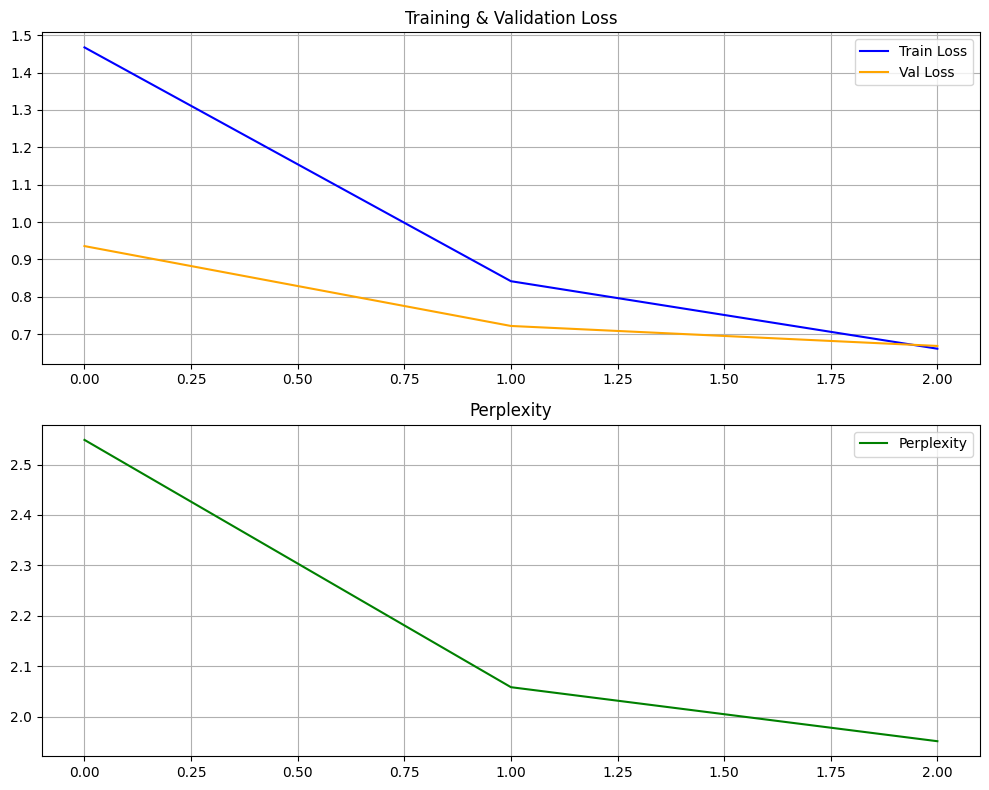

In [ ]:
optimizer = bnb.optim.AdamW8bit(
    model.parameters(),
    lr=Config.LEARNING_RATE,
    betas=(0.9, 0.999),
    weight_decay=0.01
)
# optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=Config.EPOCHS
)

criterion = LabelSmoothing(vocab_size=EN_VOCAB_LEN, padding_idx=EN_PAD_ID, smoothing=0.1)

tz = timezone("Etc/GMT-7")
now = datetime.datetime.now(tz).strftime("%d-%m-%Y_%Hh%Mm")

print(f"Starting training at {now} for {Config.EPOCHS} epochs...")
train_losses, val_losses, pps = train(model, optimizer, scheduler, criterion, train_loader, val_loader, device, Config.EPOCHS)

save_path = f"Transformer_ViEn_{Config.EPOCHS}ep_{now}.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_losses, label="Train Loss", color='blue')
ax1.plot(val_losses, label="Val Loss", color='orange')
ax1.set_title("Training & Validation Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(pps, label="Perplexity", color='green')
ax2.set_title("Perplexity")
ax2.legend()
ax2.grid(True)

save_path = f"training_curve_{now}.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

print(f"Đã lưu biểu đồ tại: {save_path}")
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os

# ==========================================
# 1. CÁC HÀM PHỤ TRỢ (HELPER FUNCTIONS)
# ==========================================
def ids2sentence(ids, vocab_map):
    tokens = []
    # Bỏ qua các token đặc biệt khi convert sang text
    special_ids = [EN_SOS_ID, EN_EOS_ID, EN_PAD_ID] 
    for i in ids:
        if i not in special_ids:
            if str(i) in vocab_map:
                tokens.append(vocab_map[str(i)])
    return " ".join(tokens).replace("_", " ")

# ==========================================
# 2. LOGIC BEAM SEARCH (CORE ALGORITHM)
# ==========================================
def beam_search_decode(model, src, beam_size=3, max_len=128):
    """
    Thực hiện Beam Search decoding cho một batch input.
    """
    batch_size = src.shape[0]
    
    # --- A. Encode Source ---
    src_mask = generate_padding_mask(src, VI_PAD_ID).to(device)
    src_emb = model.src_embed(src)
    src_emb = model.pos_embedding(src_emb)
    enc_output = model.encoder(src_emb, src_padding_mask=src_mask)

    # --- B. Chuẩn bị dữ liệu cho Beam Search ---
    # Nhân bản (Expand) Encoder Output và Mask để khớp với kích thước (Batch * Beam)
    # Ví dụ: Batch=2, Beam=3 => Đang xử lý 6 chuỗi song song
    enc_output = enc_output.repeat_interleave(beam_size, dim=0) # [Batch*Beam, Seq, Dim]
    src_mask = src_mask.repeat_interleave(beam_size, dim=0)     # [Batch*Beam, Seq]

    # Khởi tạo Decoder Input: Tất cả bắt đầu bằng SOS
    decoder_input = torch.full((batch_size * beam_size, 1), EN_SOS_ID, device=device)
    
    # Khởi tạo điểm số (Log Probabilities)
    # Beam đầu tiên của mỗi mẫu có điểm 0, các beam còn lại là -infinity
    # Điều này để ép buộc bước đầu tiên chỉ chọn từ 1 nguồn (tránh trùng lặp)
    scores = torch.full((batch_size * beam_size,), -1e9, device=device)
    scores[::beam_size] = 0.0 # Gán 0 cho index 0, 3, 6... (nếu beam=3)

    # --- C. Vòng lặp Decoding ---
    for _ in range(max_len):
        # 1. Tạo mask cho decoder
        tgt_mask = generate_subsequence_mask(decoder_input.shape[1]).to(device)
        tgt_padding_mask = generate_padding_mask(decoder_input, EN_PAD_ID).to(device)

        # 2. Forward Decoder
        tgt_emb = model.tgt_embed(decoder_input)
        tgt_emb = model.pos_embedding(tgt_emb)
        
        dec_output = model.decoder(
            tgt_emb, 
            enc_output, 
            target_mask=tgt_mask, 
            target_padding_mask=tgt_padding_mask, 
            memory_padding_mask=src_mask
        )
        
        # 3. Dự đoán từ tiếp theo
        generator_out = model.generator(dec_output) # [Batch*Beam, Seq, Vocab]
        next_token_logits = generator_out[:, -1, :] # Lấy token cuối: [Batch*Beam, Vocab]
        next_token_probs = F.log_softmax(next_token_logits, dim=-1)

        # 4. Tính điểm tích lũy
        # scores hiện tại shape [Batch*Beam] -> view thành [Batch*Beam, 1] để cộng
        candidates_scores = scores.unsqueeze(1) + next_token_probs # [Batch*Beam, Vocab]

        # 5. Chọn Top-K beam tốt nhất cho MỖI mẫu trong batch
        vocab_size = candidates_scores.shape[-1]
        # Reshape về [Batch, Beam * Vocab] để tìm topk trên toàn bộ không gian beam của 1 mẫu
        candidates_scores = candidates_scores.view(batch_size, -1)
        
        # Lấy Top-K điểm số và chỉ số (indices)
        topk_scores, topk_indices = torch.topk(candidates_scores, beam_size, dim=1) # [Batch, Beam]

        # 6. Truy vết (Backtrack) để cập nhật decoder input
        # topk_indices đang là chỉ số phẳng (0 -> Beam*Vocab), cần giải mã ra:
        # - Nó thuộc Beam cũ nào? (beam_idx)
        # - Token mới là gì? (token_idx)
        prev_beam_indices = topk_indices // vocab_size 
        next_token_indices = topk_indices % vocab_size

        # Cập nhật lại scores
        scores = topk_scores.view(-1) # Flatten lại thành [Batch*Beam]

        # Tái tạo lại decoder_input dựa trên beam được chọn
        new_decoder_input = []
        for b in range(batch_size):
            for k in range(beam_size):
                # Lấy index của beam cũ (cần tính offset theo batch)
                prev_beam_idx_in_batch = prev_beam_indices[b, k].item()
                global_prev_idx = b * beam_size + prev_beam_idx_in_batch
                
                # Lấy chuỗi token cũ
                prev_seq = decoder_input[global_prev_idx]
                
                # Lấy token mới
                new_token = next_token_indices[b, k].item()
                
                # Nối vào
                new_seq = torch.cat([prev_seq, torch.tensor([new_token], device=device)])
                new_decoder_input.append(new_seq)
        
        # Stack lại thành tensor [Batch*Beam, Seq+1]
        decoder_input = torch.stack(new_decoder_input)

        # (Optional) Nếu tất cả các beam tốt nhất đều đã gặp EOS thì dừng sớm
        # Để code đơn giản, ta cứ chạy hết max_len hoặc để bước hậu xử lý lo liệu.

    # --- D. Trả về kết quả ---
    # Chỉ lấy Beam tốt nhất (Beam 0) cho mỗi batch
    final_sequences = []
    for b in range(batch_size):
        best_seq = decoder_input[b * beam_size]
        final_sequences.append(best_seq.tolist())
        
    return final_sequences

# ==========================================
# 3. HÀM TEST BLEU (MAIN EVALUATION)
# ==========================================
def test_bleu(model, test_loader, beam_size=5, n_gram=4, max_generated_token_len=128):
    # Cài đặt thư viện nếu chưa có
    try:
        from torchmetrics.text import BLEUScore
        bleu_metric = BLEUScore(n_gram=n_gram)
    except (ImportError, NameError):
        print("⚠️ Đang cài torchmetrics...")
        os.system('pip install torchmetrics')
        from torchmetrics.text import BLEUScore
        bleu_metric = BLEUScore(n_gram=n_gram)

    model = model.to(device)
    model.eval()
    
    all_source = []
    all_preds = []
    all_target = []
    limit = 300
    print(f"🚀 Bắt đầu đánh giá với BEAM SEARCH (k={beam_size})...")
    
    with torch.no_grad():
        for src, _, tgt_label in tqdm(test_loader, desc="Testing BLEU"):
            src = src.to(device)
            if limit == 0:
                break
            limit -=1
            # --- GỌI BEAM SEARCH ---
            batch_preds = beam_search_decode(model, src, beam_size, max_generated_token_len)
            
            # --- Hậu xử lý (Cắt chuỗi tại EOS) ---
            processed_preds = []
            for seq in batch_preds:
                try:
                    # Tìm vị trí EOS đầu tiên
                    eos_idx = seq.index(EN_EOS_ID)
                    processed_preds.append(seq[:eos_idx])
                except ValueError:
                    # Nếu không thấy EOS, lấy toàn bộ
                    processed_preds.append(seq)

            all_preds.extend(processed_preds)
            all_target.extend(tgt_label.tolist())
            all_source.extend(src.tolist())
    # --- Tính điểm BLEU ---
    # Convert ID sang Text
    sources = [ids2sentence(s, vi_id2token) for s in all_source]
    preds_text = [ids2sentence(p, en_id2token) for p in all_preds]
    target_text = [ids2sentence(t, en_id2token) for t in all_target]

    # In mẫu kiểm tra
    print("\n" + "="*40)
    print(f"🔍 MẪU DỊCH THỬ (Beam Size: {beam_size})")
    print("="*40)
    for i in range(min(3, len(sources))):
        print(f"🇻🇳 Input : {sources[i]}")
        print(f"🇬🇧 Target: {target_text[i]}")
        print(f"🤖 Model : {preds_text[i]}")
        print("-" * 30)

    # Tính score
    score = bleu_metric(preds_text, [[t] for t in target_text])
    print(f"\n🏆 BLEU Score: {score.item():.4f}")
    return sources, preds_text, target_text

In [ ]:
class Config:
    D_MODEL = 256
    BATCH_SIZE = 8
    MHA_NUMHEADS = 8
    FF_DROPOUT = 0.15
    MHA_DROPOUT = 0.15
    PE_DROP_OUT = 0.15
    EPSILON_TERM = 1e-5
    N_ENCODERS = 3
    N_DECODERS = 3
    FF_SCALE = 4
    LEARNING_RATE = 1e-3
    MAX_LEN = 128
    EPOCHS = 10

    # --- ĐIỀN SỐ CỐ ĐỊNH (Dựa trên log cũ của bạn) ---
    # Source là Tiếng Việt
    SRC_VOCAB_SIZE = 45864 
    # Target là Tiếng Anh
    TGT_VOCAB_SIZE = 69025

config_dict = {k.lower(): v for k, v in Config.__dict__.items() if not k.startswith("__")}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on: {device}")

# 2. Khởi tạo lại kiến trúc Model
# Lưu ý: Cần chắc chắn bạn đã chạy các cell khai báo class Transformer, Encoder, Decoder... trước đó
src_embed = Embedding(Config.D_MODEL, Config.SRC_VOCAB_SIZE)
tgt_embed = Embedding(Config.D_MODEL, Config.TGT_VOCAB_SIZE)

model = Transformer(
    d_model=Config.D_MODEL,
    tgt_vocab_size=Config.TGT_VOCAB_SIZE,
    src_embed=src_embed,
    tgt_embed=tgt_embed,
    n_encoders=Config.N_ENCODERS,
    n_decoders=Config.N_DECODERS
).to(device)

# 3. Load Trọng số từ file .pt
# Đường dẫn bạn vừa cung cấp
checkpoint_path = "/kaggle/working/Transformer_ViEn_3ep_23-12-2025_19h35m.pt"

try:
    print(f"⏳ Loading model from {checkpoint_path}...")
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    print("✅ Load model thành công! Sẵn sàng test.")
except FileNotFoundError:
    print("❌ Không tìm thấy file model! Hãy kiểm tra lại đường dẫn.")
except Exception as e:
    print(f"❌ Lỗi khi load model: {e}")

# 4. Chạy hàm Test (Nếu test_loader đã có)
source_sentences, predicted_sentences, target_sentences = test_bleu(model, test_loader)

🚀 Running on: cuda
Source Embedding initialized with 11,741,184 params
Target Embedding initialized with 17,670,400 params
Encoder initialized with 2,855,168 params
Decoder initialized with 3,348,992 params
Generator initialized with 17,739,425 params
Transformer Model initialized with 53,355,169 params
⏳ Loading model from /kaggle/working/Transformer_ViEn_3ep_23-12-2025_19h35m.pt...
✅ Load model thành công! Sẵn sàng test.
🚀 Bắt đầu đánh giá với BEAM SEARCH (k=5)...


Testing BLEU:  27%|██▋       | 300/1120 [37:05<1:41:24,  7.42s/it]



🔍 MẪU DỊCH THỬ (Beam Size: 5)
🇻🇳 Input : thực trạng kiến thức và thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố ảnh hưởng tại tỉnh viêng chăn , <unk> lào , năm 2017
🇬🇧 Target: knowledge , practices in public health service utilization among health insurance card ’ s <unk> and influencing factors in vientiane , lao
🤖 Model : current status of knowledge and practice of health insurance card in using medical examination services in public health facilities and some factors affecting in cambodia , lao cai , lao cai , 2017
------------------------------
🇻🇳 Input : mô tả thực trạng kiến thức , thực hành của người có thẻ bảo hiểm y tế trong sử dụng dịch vụ khám chữa bệnh ở các cơ sở y tế công và một số yếu tố liên quan tại tỉnh viêng chăn , cộng hoà <unk> lào năm 2017 .
🇬🇧 Target: describe knowledge , practices in public health service utilization among health insurance card 's <unk> and influencing factors in vientiane , 

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
# from google.colab import userdata
# Retrieve the API key from Colab secrets
genai.configure(api_key='GEMINIKEY')

# Initialize the Generative Model
gemini_model = genai.GenerativeModel('gemini-2.5-flash-lite') # Using a capable model for evaluation
print("Gemini API configured successfully.")

Gemini API configured successfully.


In [ ]:
import re
from tqdm import tqdm
from time import sleep
def create_llm_judge_prompt(source, predicted, reference):
    return f"""You are an expert in evaluating machine translations. You will be provided with a Source sentence, a Machine Translation (Predicted), and a Human Reference Translation. 
    
Your task is to rate the quality of the Machine Translation on a scale of 1 to 10.

Scale Definition:
1: Nonsense - No meaning is conveyed; hallucination or completely wrong.
2: Very Poor - Severe inaccuracies; barely understandable.
3: Poor - Conveying some isolated meaning, but grammatically broken or very confusing.
4: Below Average - The gist is there, but with critical errors in accuracy or grammar.
5: Average - Understandable, but awkward phrasing or noticeable errors.
6: Above Average - Mostly correct meaning, but lacks fluency or has minor grammatical slips.
7: Good - Accurate and readable, but may not sound completely native.
8: Very Good - Fluent and accurate; only very minor stylistic imperfections.
9: Excellent - Near-perfect translation, preserving nuance and tone.
10: Perfect - Indistinguishable from a professional human translator.

Please provide your rating as a single integer (1-10) at the end of your response.
Do not include any other text besides your justification and the final score.

Source: {source}
Predicted: {predicted}
Reference: {reference}
Rating:
"""

def evaluate_with_gemini_batch(sources, predicted_sentences, target_sentences, model, batch_size=10):
    eval_scores = []
    
    # Iterate through data in batches
    for i in tqdm(range(0, len(sources), batch_size), desc="Evaluating with Gemini"):
        sleep(1)
        batch_sources = sources[i:i + batch_size]
        batch_predicted = predicted_sentences[i:i + batch_size]
        batch_targets = target_sentences[i:i + batch_size]

        prompts = [
            create_llm_judge_prompt(src, pred, tar[0]) 
            for src, pred, tar in zip(batch_sources, batch_predicted, batch_targets)
        ]

        try:
            # Note: Ensure your model object supports list input for 'prompts'. 
            # If using standard Google GenAI SDK, you might need to loop individually 
            # or use specific batching API methods.
            responses = model.generate_content(prompts, generation_config={'temperature': 0})
            
            # Handle case where response might be a single object vs list based on SDK version
            if not isinstance(responses, list) and hasattr(responses, 'text'):
                 # Fallback if API returns single response for single prompt
                 responses = [responses] 

            for res in responses:
                try:
                    text = res.text.strip()
                    # REGEX UPDATE: Looks for 10 or 1-9
                    matches = re.findall(r'\b(10|[1-9])\b', text)
                    
                    if matches:
                        # Get the last number found in the response
                        eval_scores.append(int(matches[-1]))
                    else:
                        eval_scores.append(None)
                except ValueError:
                    # Handle cases where safety filters block the text
                    eval_scores.append(None)
                    
        except Exception as e:
            print(f"Error during batch generation: {e}")
            eval_scores.extend([None] * len(batch_sources))

    return eval_scores

In [ ]:
# Example usage (uncomment to run):
if 'gemini_model' in locals():
    sample_sources = source_sentences
    sample_predicted = predicted_sentences
    sample_targets = target_sentences

    gemini_scores = evaluate_with_gemini_batch(
        sample_sources,
        sample_predicted,
        sample_targets,
        gemini_model,
        batch_size=10
    )
    print(f"\nGemini Evaluation Scores for sample: {gemini_scores}")

    # Calculate average score (ignoring Nones)
    valid_scores = [score for score in gemini_scores if score is not None]
    if valid_scores:
        average_gemini_score = sum(valid_scores) / len(valid_scores)
        print(f"Average Gemini Score for sample: {average_gemini_score:.2f}")
    else:
        print("No valid scores obtained from Gemini evaluation.")
else:
    print("Gemini model not initialized. Please run the setup cells first.")

Evaluating with Gemini: 100%|██████████| 240/240 [07:04<00:00,  1.77s/it]


Gemini Evaluation Scores for sample: [6, 7, 10, 9, 7, 7, 7, 7, 7, 6, 8, 7, 7, 9, 9, 10, 10, 6, 6, 7, 9, 4, 7, 7, 8, 10, 1, 7, 9, 6, 10, 9, 8, 9, 6, 7, 9, 7, 6, 6, 8, 7, 7, 8, 9, 6, 7, 7, 4, 1, 7, 4, 7, 6, 7, 9, 9, 7, 3, 9, 9, 7, 7, 10, 9, 9, 7, 6, 7, 7, 3, 7, 7, 8, 10, 9, 6, 10, 8, 4, 10, 9, 7, 7, 4, 7, 7, 8, 6, 7, 6, 3, 7, 10, 4, 7, 7, 7, 9, 10, 7, 4, 9, 7, 6, 9, 9, 9, 10, 8, 6, 4, 7, 7, 9, 9, 8, 7, 9, 9, 7, 8, 1, 9, 6, 9, 10, 6, 9, 9, 8, 7, 7, 9, 10, 10, 10, 10, 10, 6, 7, 10, 7, 6, 8, 5, 7, 10, 4, 8, 9, 6, 8, 10, 7, 1, 8, 7, 9, 10, 6, 2, 7, 9, 7, 9, 4, 6, 9, 7, 9, 7, 9, 2, 6, 7, 7, 6, 7, 2, 8, 5, 9, 7, 9, 8, 7, 6, 7, 7, 6, 10, 6, 6, 7, 7, 9, 9, 6, 7, 2, 5, 5, 7, 7, 7, 7, 7, 9, 7, 7, 7, 9, 7, 10, 6, 9, 7, 7, 7, 9, 7, 9, 10, 10, 8, 10, 10, 7, 10, 9, 9, 9, 7, 6, 7, 2, 2, 8, 6]
Average Gemini Score for sample: 7.29


In [ ]:
!pip install sacrebleu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import sacrebleu
ter = sacrebleu.corpus_ter(
    predicted_sentences,
    [target_sentences]   # list of reference lists
)

print("TER:", ter.score)

TER: 55.87836497122826


In [ ]:
from nltk.translate.meteor_score import meteor_score

meteor_scores = [
    meteor_score([ref.split()], pred.split())
    for pred, ref in zip(predicted_sentences, target_sentences)
]

print("METEOR avg:", sum(meteor_scores) / len(meteor_scores))


METEOR avg: 0.6038183713051335


# Load model & predict

In [ ]:
class PredDataset(Dataset):
  def __init__(self, vi):
    self.vi = [tokens + [VI_EOS_ID] for tokens in vi]

  def __len__(self):
    return len(self.vi)

  def __getitem__(self, idx):
    return torch.tensor(self.vi[idx])

def pred_collate_fn(batch):
  vi_ts = pad_sequence(batch, batch_first=True, padding_value=VI_PAD_ID)
  return vi_ts.to(device)

In [ ]:
#

def predict(model, sentences, max_generated_token_len=5, beam_size=5):
  sentences = [sentence.lower() for sentence in sentences]
  vi = [[vi_token2id.get(token, VI_UNK_ID) for token in sentence.split()] for sentence in sentences]

  model = model.to(device)
  model.eval()
  with torch.no_grad():
    src_embed = model.src_embed
    tgt_embed = model.tgt_embed
    encoder = model.encoder
    decoder = model.decoder
    generator = model.generator

    all_preds = []

    pred_dataset = PredDataset(vi)
    loader = DataLoader(pred_dataset, batch_size=config_dict['batch_size'], collate_fn=pred_collate_fn)

    for vi in tqdm(loader):
      src_padding_mask = generate_padding_mask(vi, VI_PAD_ID)
      enc_o = encoder(src_embed(vi), src_padding_mask=src_padding_mask)

      batch_size = vi.shape[0]

      batch_pred = []
      # for each enc_o
      for i in range(batch_size):
        encoder_out = enc_o[i].unsqueeze(0)  # (1, seq_len, d_model)
        enc_pad_mask_i = src_padding_mask[i].unsqueeze(0)

        beams = [(torch.tensor([EN_SOS_ID], device=device), 0.0, False)]

        # depth
        for _ in range(max_generated_token_len):
          candidates = []

          for seq, score, finished in beams:
            if finished:
              candidates.append((seq, score, True))
              continue

            seq_input = seq.unsqueeze(0)  # (1, seq_len)

            dec_out = decoder(tgt_embed(seq_input), encoder_out, memory_padding_mask=src_padding_mask)
            logits = generator(dec_out)

            # last token
            log_probs = torch.log_softmax(logits[:, -1, :], dim=-1).squeeze(0)  # (1, vocab_len)

            # topk
            topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)
            for log_p, token_id in zip(topk_log_probs, topk_ids):
              new_seq = torch.cat([seq, torch.tensor([token_id], device=device)])
              new_score = score + log_p.item()
              new_finished = token_id == EN_EOS_ID
              candidates.append((new_seq, new_score, new_finished))

          # sorted by score, topk
          candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
          beams = candidates[:beam_size]

          # all finished = True
          if all(f for _, _, f in beams):
              break

        beams = [seq for seq, _, _ in beams] # [beam_size]
        sentences = [ids2sentence(seq.cpu().tolist(), en_id2token) for seq in beams]
        batch_pred.append(sentences)

      all_preds.extend(batch_pred)

    return all_preds  # (len_sentences, beam_size)


In [ ]:
checkpoint_path = "../models/Transformer_EnVi_10ep_16-12-2025_23h19m.pt"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

In [ ]:
predictions = predict(model, ["what is the experiment ?"], max_generated_token_len=10, beam_size=1)